In [1]:
import numpy as np
import pylab as plt
import torch
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2 #+ np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x[1:], z = z[1:])
obs = swyft.Sample(x = x[0], z = z[0])

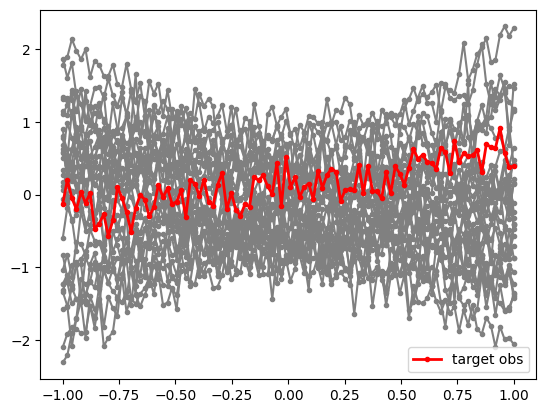

In [4]:
for i in range(30):
    plt.plot(y, samples[i]['x'], marker='.', color='0.5')
plt.plot(y, obs['x'], marker='.', color='r', lw = 2, label = 'target obs')
plt.legend(loc=0)

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Linear(Nbins, 3)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z']), s

In [6]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, default_root_dir='/tmp/lightning_logs')
dm = swyft.SwyftDataModule(samples)
network = Network()
trainer.fit(network, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 303   
1 | logratios  | LogRatioEstimator_1dim | 52.2 K
------------------------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params
0.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /tmp/lightning_logs/lightning_logs/version_2/checkpoints/epoch=5-step=1500.ckpt


Mean weight for z[0]: -0.03864
Mean weight for z[1]: 0.00030
Mean weight for z[2]: 0.00037


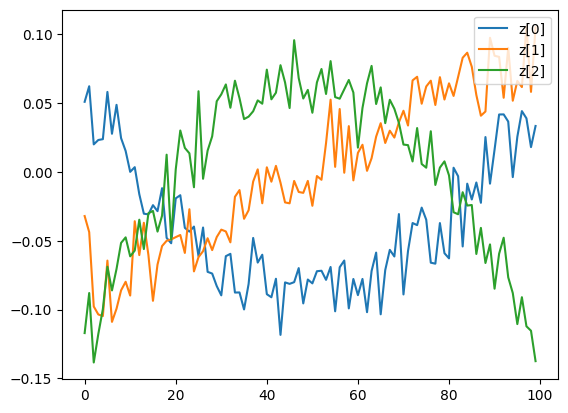

In [7]:
weight = network.summarizer.state_dict()['weight']
for i in range(3):
    plt.plot(weight[i], label='z[%i]'%i);
    print("Mean weight for z[%i]: %.5f"%(i, weight[i].mean().item()))
plt.legend(loc=1);

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

/Users/knana/miniforge3/envs/new_env/lib/python3.12/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


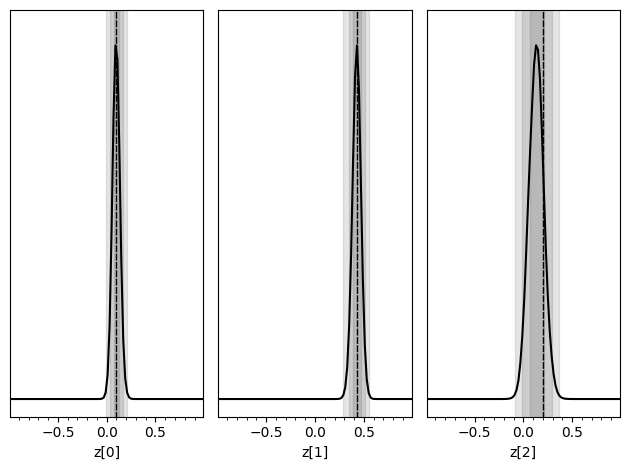

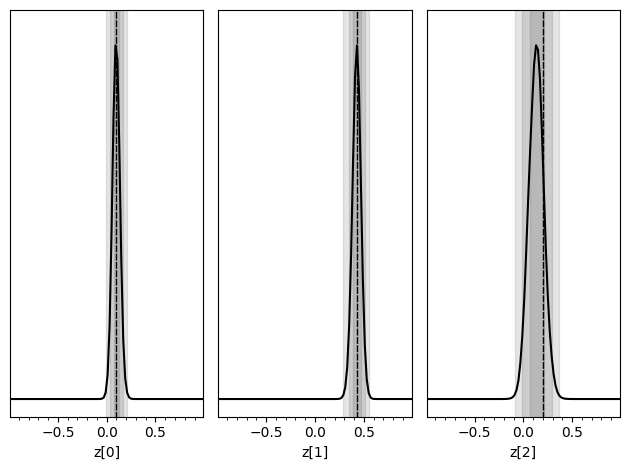

In [8]:
prior_samples = swyft.Samples(z = np.random.rand(100_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(3)], truth=truth)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 250it [00:00, ?it/s]

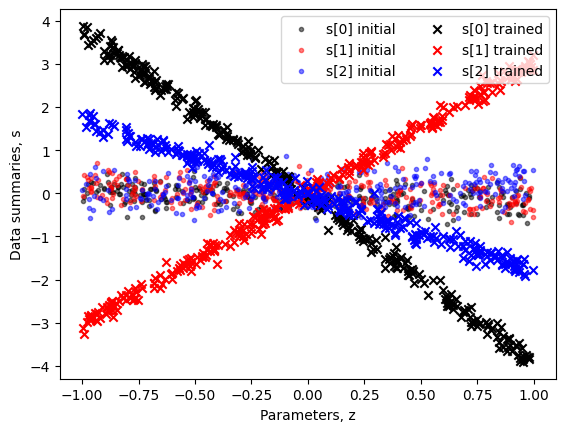

In [9]:
pred_untrained = trainer.infer(Network(), samples[:300], samples[:300], return_sample_ratios = False, batch_size = 1)
pred_trained = trainer.infer(network, samples[:300], samples[:300], return_sample_ratios = False, batch_size = 1)
Z = []; S = []
for i in range(len(pred_untrained)):
    s1 = pred_untrained[i][1][0,:,0].numpy()
    z1 = pred_untrained[i][0].params.numpy()[0,:,0]
    s2 = pred_trained[i][1][0,:,0].numpy()
    z2 = pred_trained[i][0].params.numpy()[0,:,0]
    Z.append([z1, z2]); S.append([s1, s2])
Z = np.array(Z); S = np.array(S)
plt.scatter(Z[:,0,0], S[:,0,0], color='k', label='s[0] initial', marker='.', alpha = 0.5);
plt.scatter(Z[:,0,1], S[:,0,1], color='r', label='s[1] initial', marker='.', alpha = 0.5);
plt.scatter(Z[:,0,2], S[:,0,2], color='b', label='s[2] initial', marker='.', alpha = 0.5);
plt.scatter(Z[:,1,0], S[:,1,0], color='k', label='s[0] trained', marker='x');
plt.scatter(Z[:,1,1], S[:,1,1], color='r', label='s[1] trained', marker='x');
plt.scatter(Z[:,1,2], S[:,1,2], color='b', label='s[2] trained', marker='x');
plt.xlabel("Parameters, z");
plt.ylabel("Data summaries, s")
plt.legend(loc=1, ncol = 2);